In [1]:
pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.3/803.3 kB 11.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.3/614.3 kB 30.8 MB/s eta 0:00:00
 

In [166]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#### Tokens

In [ ]:
#  1 token ~= 4 chars in English
#  1-2 sentence ~= 30 tokens
#  1 paragraph ~= 100 tokens
#  1,500 words ~= 8 to204ken#s

 # Depending on the model used, requests can use up to 4097 tokens shared between prompt and completio
# n. If your prompt is 4000 tokens, your completion can be 97 tokens at moens

## Utilisation de LLaMA2 sur une petite base de données avec une seule table 

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline 
from langchain.llms import HuggingFacePipeline
from langchain import PromptTemplate, LLMChain
import torch 
import os
import pandas as pd

/home/despadm/miniconda3/envs/llm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
model = AutoModelForCausalLM.from_pretrained("huggyllama/llama-7b") # j'utilise LLaMA 7B sur 10Go

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


In [11]:
tokenizer = AutoTokenizer.from_pretrained("huggyllama/llama-7b")

In [178]:
pipe = pipeline("text-generation",model=model,tokenizer = tokenizer,max_length =3500,do_sample=True,temperature=0.3,top_p=0.95)

template = """
Write a SQL query that retrieves data from the table '{Table}'.
Select the columns {Columns} based on the following question: 
{question}.
Just generate the query without explanation
"""


prompt = PromptTemplate(template=template, input_variables=["Table","question","Columns"])

local_llm = HuggingFacePipeline(pipeline=pipe)
llm_chain = LLMChain(prompt=prompt,llm=local_llm)

In [179]:
llm = Ollama(base_url='http://localhost:11434',
model="llama2")
def get_llm_response(tble,question,cols):
    llm_chain = LLMChain(prompt=prompt,llm=llm)
    response= llm_chain.run({"Table" : tble,"question" :question, "Columns" : cols})
    print(response)

## Premières Requêtes sur LLaMA2

In [115]:
# exemple de code pour la base de données 
tble = "employee"
cols = ["id","name","date_of_birth","band","manager_id"]
question = "Query the count of employees in band L6"
get_llm_response(tble,question,cols)

SELECT COUNT(*) FROM employee WHERE band = 'L6';


In [116]:
question = "Query the count of employees in band L6 and over 40 years of age"
get_llm_response(tble,question,cols)
# GPT3.5 answer : SELECT COUNT(*) FROM employees WHERE band='L6' AND date_of_birth >= ( CURDATE() - INTERVAL 40 YEAR );

SELECT id, name, date_of_birth, band, manager_id FROM employee WHERE band = 'L6' AND age > 40;


On remarque deja que le modèle commence à halluciner en créant des attributs : l'attribut âge n'existe pas 

In [117]:
question =  "Count the number of employees in each 'band'."
get_llm_response(tble,question,cols)
# GPT3.5 answer : SELECT band, COUNT(*) AS employee_count FROM employee GROUP BY band;

SELECT id, name, date_of_birth, band, manager_id
FROM employee
GROUP BY band
COUNT(*) as count;


## Case 1: Text-to-SQL requêtes sans prompting avec SQLCODER:7B
Let’s create a SQLDatabaseChain to create and execute SQL queries.

SQLCoder is a 15B parameter model that is fine-tuned on a base StarCoder model. It slightly outperforms gpt-3.5-turbo for natural language to SQL generation tasks on the sql-eval framework, and outperforms popular open-source models.

In [6]:
from langchain_community.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain
from langchain_community.llms import Ollama

In [2]:
%env http_proxy=

env: http_proxy=


In [3]:
%env https_proxy=

env: https_proxy=


In [9]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")
llm = Ollama(base_url='http://localhost:11434',
model="sqlcoder:7b") # utilisation de sqlcoder:7b
# print(db.table_info)
db_chain = SQLDatabaseChain.from_llm(llm, db, verbose=True)

In [105]:
db_chain.run("How many employees are there?")



> Entering new SQLDatabaseChain chain...
How many employees are there?
SQLQuery:SELECT COUNT(*) AS total_employees FROM "Employee"
SQLResult: [(8,)]
Answer:8
> Finished chain.


'8'

 La requête la plus simple marche sur ce modèle et trouve le bon résultat

In [112]:
from langchain.chains import create_sql_query_chain
# au lieu d'éxecuter chaque requête et d'avoir plein d'erreur je préfère juste print les requetes 
chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "Show customers (just their full names, customer ID and country) who are not in the US"})
print(response)

# Correct Answer: select customerid, firstname, lastname, country from customer where not country = 'USA';


SELECT c.customer_id, c.full_name, c.address_line_1, a.address_country FROM customers AS c JOIN addresses AS a ON a.address_id = c.address_id WHERE a.address_country != 'US';


 On remarque que sur des requêtes pourtant pas très compliquées, sans prompt sqlcoder:7b ne donne pas des requêtes satisfaisantes. On a encore de l'hallucination ( invention de l'attribut address ) 

## Case 2 : Few Shot Learning avec SQLCODER:7B juste avec des exemples

Let’s begin by preparing an array of examples, each containing the input prompt, the expected SQL query, the result, and the final answer. We will use these examples to create a template for prompting the LLM, using the PromptTemplate provided by LangChain.

#### Vectorizing the examples and using an example selector
Next, we will convert our examples into vector form using sentence transformers and employ a semantic similarity example selector. While vectorization is not strictly necessary, it’s preferred as it transforms our sentences into embeddings, capturing the meaning and context of sentences. This enables LLMs to leverage semantic information, resulting in better-generated responses.

In [14]:
examples = [
        {
            "input":  "Provide a query showing Customers (just their full names, customer ID and country) who are not in the US.?",
            "sql_cmd": "select customerid, firstname, lastname, country from customer where not country = 'USA';",
        },
        {
            "input": " Provide a query only showing the Customers from Brazil.",
            "sql_cmd": "select * from customer where country = 'Brazil';",
        },
        {
            "input": "Provide a query showing the Invoices of customers who are from Brazil. The resultant table should show the customer's full name, Invoice ID, Date of the invoice and billing country.",
            "sql_cmd": "select c.firstname, c.lastname, i.invoiceid, i.invoicedate, i.billingcountry from customer as c, invoice as i where c.country = 'Brazil' and c.customerid = i.customerid;",
        },
     {
            "input":  " Provide a query showing only the Employees who are Sales Agents.",
            "sql_cmd": "select * from employee where employee.title = 'Sales Support Agent';",
        },
     {
            "input":  " Provide a query showing the invoices of customers who are from Brazil.",
            "sql_cmd": "select * from customer as c, invoice as i where c.country = 'Brazil' and c.customerid = i.customerid;",
        },
]

example_prompt = PromptTemplate(
    input_variables=["input", "sql_cmd"],
    template="\nQuestion: {input}\nSQLQuery: {sql_cmd}",
)

from langchain.prompts import SemanticSimilarityExampleSelector
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma


embeddings= HuggingFaceEmbeddings()

to_vectorize = [" ".join(example.values()) for example in examples]

vectorstore = Chroma.from_texts(to_vectorize, embeddings, metadatas=examples)

example_selector = SemanticSimilarityExampleSelector(
    vectorstore=vectorstore,
    k=1,
)



#### Setting up the few shot prompt
Now, let’s configure the few-shot prompt variable that we’ll be passing to the large language model.

In [26]:
from langchain.prompts import FewShotPromptTemplate
from langchain.chains.sql_database.prompt import PROMPT_SUFFIX, _mysql_prompt

#print(PROMPT_SUFFIX)

few_shot_prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix=_mysql_prompt,
    suffix=PROMPT_SUFFIX, 
    input_variables=["input", "table_info", "top_k"], #These variables are used in the prefix and suffix
)

Finally, let’s prompt the LLM using the few-shot prompt and examine the result. 

In [78]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_community.llms import Ollama
from langchain_community.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
llm = Ollama(model="sqlcoder:7b")

local_chain = SQLDatabaseChain.from_llm(llm, db, prompt=few_shot_prompt, use_query_checker=True, 
                                        verbose=True, return_sql=True,)
local_chain.run("What are some example tracks by composer Johann Sebastian Bach ?")



> Entering new SQLDatabaseChain chain...
What are some example tracks by composer Johann Sebastian Bach ?
SQLQuery:
> Finished chain.


'SELECT t.trackid FROM track t JOIN "genre" g ON t.genreid = g.genreid WHERE g.firstname ILIKE \'%johann%sebastian%bach%\''

In [50]:
local_chain.run("Provide a query that includes the purchased track name AND artist name with each invoice line item")



> Entering new SQLDatabaseChain chain...
Provide a query that includes the purchased track name AND artist name with each invoice line item
SQLQuery:
> Finished chain.


'SELECT "InvoiceItemItem"."TrackId", "Track"."Name" AS "Purchased Track Name", "Genre"."Name" AS "Artist Name" FROM "InvoiceLine" JOIN "Track" ON "InvoiceItemick"."TrackId" = "Track"."TrackId" JOIN "Genre" ON "Track"."GenreId" = "Genre"."GenreId";'

In [53]:
local_chain.run("Provide a query showing the Invoices of customers who are from Brazil. The resultant table should show the customer's full name, Invoice ID, Date of the invoice and billing country.")



> Entering new SQLDatabaseChain chain...
Provide a query showing the Invoices of customers who are from Brazil. The resultant table should show the customer's full name, Invoice ID, Date of the invoice and billing country.
SQLQuery:
> Finished chain.


"SELECT c.first_name, c.last_name, i.invoiceid, to_char(i.invoicedate,'YYYY-MM-DD') AS invoice_date, b.billing_country FROM customer AS c JOIN invoice AS i ON c.customerid = i.customerid JOIN billing AS b ON i.billingid = b.billingid WHERE b.billing_country ilike '%Braz%' ;"

## Evaluation des performances du modèle SQLCODER:15B sans prompt

In [10]:
%env http_proxy=

env: http_proxy=


In [11]:
%env https_proxy=

env: https_proxy=


In [12]:
from langchain_community.utilities import SQLDatabase
from langchain_experimental.sql import SQLDatabaseChain
from langchain_community.llms import Ollama
from langchain.chains import create_sql_query_chain

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
llm = Ollama(base_url='http://localhost:11434',
model="sqlcoder:15b")
chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "What are some example tracks by composer Johann Sebastian Bach? "})
print(response)

Select t.trackid,
       t.name,
       t.albumid
  from track as t join genre as g on t.genreid = g.genreid
 where lower(t.composer) like '%johann%sebastian%bach%'
   order by t.trackid;
<|endoftext|>


 le SQLCODER:15B a l'air d'avoir du mal sans plusieurs prompts d'exemples même pour une simple requête. ça dépend vraiment des fois 

Pour chaque requête j'éxecute la correcte et celle de SQLCODER:15B sur MySQL et je compare : ✅ si la requête a fonctionné et❌ sinon 

In [ ]:
# Provide a query only showing the Customers from Brazil.
#  SQLCODER:15B ANSWER : Select customer.customerid, customer.lastname From customer Where customer.country = 'Brazil'; ✅
#  CORRECT ANSWER : select * from customer where country = 'Brazil'; 
#
#-------------------------------------------------------------------------------------------------------------------------------------------------
#  Provide a query showing the Invoices of customers who are from Brazil. The resultant table should show the customer's full name, 
#Invoice ID, Date of the invoice and billing country.
#  SQLCODER:15B ANSWER : SELECT c.FirstName || ' ' || c.LastName AS "Customer Full Name", i.InvoiceId, i.InvoiceDate,c.Country
#                          FROM customers c JOIN invoices i ON c.CustomerId = i.CustomerId   WHERE c.Country = 'Brazil'; 
#   ❌ PROBLEMES DE PLURIEL ( customer et non customers, pareil pour invoices ) 

#  CORRECT ANSWER : select c.firstname, c.lastname, i.invoiceid, i.invoicedate, i.billingcountry from customer as c, invoice as i 
#                    where c.country = 'Brazil' and c.customerid = i.customerid; 
#-------------------------------------------------------------------------------------------------------------------------------------------------
# Provide a query showing only the Employees who are Sales Agents.
# SQLCODER:15B ANSWER : SELECT e.* FROM employee e WHERE exists (select * from track t where e.employeeid = t.composer) 
#                             and e.jobtitle like '%Sales%Agent%' order by e.lastname; ❌
#  CORRECT ANSWER : select * from employee where employee.title = 'Sales Support Agent';

#-------------------------------------------------------------------------------------------------------------------------------------------------
# Provide a query showing a unique list of billing countries from the Invoice table.
# SQLCODER:15B ANSWER : Select Distinct(BillingCountry) From Invoice; ✅
#  CORRECT ANSWER :select distinct billingcountry from invoice;
#-------------------------------------------------------------------------------------------------------------------------------------------------
# Provide a query that includes the purchased track name AND artist name with each invoice line item.
# SQLCODER:15B ANSWER : SELECT InvoiceLine.InvoiceId, InvoiceLine.TrackId,Track.Name AS track_name, Artist.Name AS artist_name FROM InvoiceLine
#                     LEFT JOIN Track ON InvoiceLine.TrackId = Track.TrackId
#                     LEFT JOIN Album on Track.AlbumId = Album.AlbumId
#                     LEFT JOIN Artist on Album.ArtistId = Artist.ArtistId; ❌
#  CORRECT ANSWER :select i.*, t.name as 'track', ar.name as 'artist' from invoiceline as i join track as t on i.trackid = t.trackid
#              	join album as al on al.albumid = t.albumid
#           	join artist as ar on ar.artistid = al.artistid


Il arrive que SQLCODER:15B transforme une classe mediatype en media_type ou de customer à customers. Ce sont souvent des erreurs de syntaxe
 Pour écrire 2 mots il faut privilégier l’utilisation d’un underscore. Par exemple il faut plutôt utiliser “date_inscription” que “DateInscription” : cette indication dans un cours de SQL montre pourquoi le modèle se trompe : il utilise les conventions déja utilisées 
 "Privilégier le singulier (mais c’est parfois un grand débat …)"

### How does SQLDatabase Chain work internally?

SQLDatabaseChain doesn't load the entire database into memory. Instead, it formulates a SQL query based on your input and then runs it against the database. The only time you may run into issues is if the SQL query result is too long and exceeds the prompt token limit for your chosen LLM. For example, davinci has a limit of about 4,000 tokens.

If we're using the SQL Database Agent (rather than the chain), it will start with listing all the tables in the db. This can also potentially cause problems if the number of tables is too large and exceeds the prompt token limit.

SQLDatabaseChain does not store entire database, it works based on metadata : it mostly includes table names, column names, primary and foreign keys, all these information together sums up to very small compared to DDL : (Metadata is data about data, providing details like structure and constraints of database elements. DDL is a subset of SQL used to define and modify the structure of a database, such as creating or altering tables )

### Using SQL Agents

Langchain has an SQL Agent wich provides a more flexible way of interacting with SQL Databaes than the SQLDatabaseChain. The main advantages of using the SQL Agent are :
- It can answer questions based on the databases schema as well as on the databases' content
- It can recover from errors by running a generated query, catching the traceback and regenerating it correctly 

In [8]:
from langchain.agents import create_sql_agent,AgentExecutor
from langchain.agents.agent_types import AgentType
from langchain_community.agent_toolkits import SQLDatabaseToolkit

In [10]:
from langchain.tools.sql_database.tool import (

ListSQLDatabaseTool,
QuerySQLDataBaseTool,
)

tools = [
QuerySQLDataBaseTool(db=db),
ListSQLDatabaseTool(db=db),
]

In [11]:
db = SQLDatabase.from_uri("sqlite:///Chinook.db")
llm = Ollama(base_url='http://localhost:11434',model="sqlcoder:15b")

In [ ]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
agent = create_sql_agent(
    llm=llm,
    toolkit=toolkit,
    verbose=True,
    agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    handle_parsing_errors=True
)


agent.run({"input": "How many employees are there"}
)

## Case 3 : Few Shot Learning avec SQLCODER:15B avec l'architecture et des exemples

I use the prompt given by SQLCODER:15B

In [16]:
TEMPLATE = """ 
### Instructions:
Your task is to convert a question into a SQL query, given a MySQL database schema.
Adhere to these rules:
- **Deliberately go through the question and database schema word by word** to appropriately answer the question
- **Use Table Aliases** to prevent ambiguity. For example, `SELECT table1.col1, table2.col1 FROM table1 JOIN table2 ON table1.id = table2.id`.
- When creating a ratio, always cast the numerator as float

### Input:
Generate a SQL query that answers the question `{query}`.
This query will run on a database whose schema is represented in this string:
CREATE TABLE [Album]
(
    [AlbumId] INTEGER  NOT NULL,
    [Title] NVARCHAR(160)  NOT NULL,
    [ArtistId] INTEGER  NOT NULL,
    CONSTRAINT [PK_Album] PRIMARY KEY  ([AlbumId]),
    FOREIGN KEY ([ArtistId]) REFERENCES [Artist] ([ArtistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE [Artist]
(
    [ArtistId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_Artist] PRIMARY KEY  ([ArtistId])
);

CREATE TABLE [Customer]
(
    [CustomerId] INTEGER  NOT NULL,
    [FirstName] NVARCHAR(40)  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [Company] NVARCHAR(80),
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60)  NOT NULL,
    [SupportRepId] INTEGER,
    CONSTRAINT [PK_Customer] PRIMARY KEY  ([CustomerId]),
    FOREIGN KEY ([SupportRepId]) REFERENCES [Employee] ([EmployeeId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE [Employee]
(
    [EmployeeId] INTEGER  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [FirstName] NVARCHAR(20)  NOT NULL,
    [Title] NVARCHAR(30),
    [ReportsTo] INTEGER,
    [BirthDate] DATETIME,
    [HireDate] DATETIME,
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60),
    CONSTRAINT [PK_Employee] PRIMARY KEY  ([EmployeeId]),
    FOREIGN KEY ([ReportsTo]) REFERENCES [Employee] ([EmployeeId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE [Genre]
(
    [GenreId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_Genre] PRIMARY KEY  ([GenreId])
);

CREATE TABLE [Invoice]
(
    [InvoiceId] INTEGER  NOT NULL,
    [CustomerId] INTEGER  NOT NULL,
    [InvoiceDate] DATETIME  NOT NULL,
    [BillingAddress] NVARCHAR(70),
    [BillingCity] NVARCHAR(40),
    [BillingState] NVARCHAR(40),
    [BillingCountry] NVARCHAR(40),
    [BillingPostalCode] NVARCHAR(10),
    [Total] NUMERIC(10,2)  NOT NULL,
    CONSTRAINT [PK_Invoice] PRIMARY KEY  ([InvoiceId]),
    FOREIGN KEY ([CustomerId]) REFERENCES [Customer] ([CustomerId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE [InvoiceLine]
(
    [InvoiceLineId] INTEGER  NOT NULL,
    [InvoiceId] INTEGER  NOT NULL,
    [TrackId] INTEGER  NOT NULL,
    [UnitPrice] NUMERIC(10,2)  NOT NULL,
    [Quantity] INTEGER  NOT NULL,
    CONSTRAINT [PK_InvoiceLine] PRIMARY KEY  ([InvoiceLineId]),
    FOREIGN KEY ([InvoiceId]) REFERENCES [Invoice] ([InvoiceId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY ([TrackId]) REFERENCES [Track] ([TrackId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE [MediaType]
(
    [MediaTypeId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_MediaType] PRIMARY KEY  ([MediaTypeId])
);

CREATE TABLE [Playlist]
(
    [PlaylistId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_Playlist] PRIMARY KEY  ([PlaylistId])
);

CREATE TABLE [PlaylistTrack]
(
    [PlaylistId] INTEGER  NOT NULL,
    [TrackId] INTEGER  NOT NULL,
    CONSTRAINT [PK_PlaylistTrack] PRIMARY KEY  ([PlaylistId], [TrackId]),
    FOREIGN KEY ([PlaylistId]) REFERENCES [Playlist] ([PlaylistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY ([TrackId]) REFERENCES [Track] ([TrackId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

CREATE TABLE [Track]
(
    [TrackId] INTEGER  NOT NULL,
    [Name] NVARCHAR(200)  NOT NULL,
    [AlbumId] INTEGER,
    [MediaTypeId] INTEGER  NOT NULL,
    [GenreId] INTEGER,
    [Composer] NVARCHAR(220),
    [Milliseconds] INTEGER  NOT NULL,
    [Bytes] INTEGER,
    [UnitPrice] NUMERIC(10,2)  NOT NULL,
    CONSTRAINT [PK_Track] PRIMARY KEY  ([TrackId]),
    FOREIGN KEY ([AlbumId]) REFERENCES [Album] ([AlbumId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY ([GenreId]) REFERENCES [Genre] ([GenreId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY ([MediaTypeId]) REFERENCES [MediaType] ([MediaTypeId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
);

/*******************************************************************************
   Create Primary Key Unique Indexes
********************************************************************************/

/*******************************************************************************
   Create Foreign Keys
********************************************************************************/
CREATE INDEX [IFK_AlbumArtistId] ON [Album] ([ArtistId]);

CREATE INDEX [IFK_CustomerSupportRepId] ON [Customer] ([SupportRepId]);

CREATE INDEX [IFK_EmployeeReportsTo] ON [Employee] ([ReportsTo]);

CREATE INDEX [IFK_InvoiceCustomerId] ON [Invoice] ([CustomerId]);

CREATE INDEX [IFK_InvoiceLineInvoiceId] ON [InvoiceLine] ([InvoiceId]);

CREATE INDEX [IFK_InvoiceLineTrackId] ON [InvoiceLine] ([TrackId]);

CREATE INDEX [IFK_PlaylistTrackTrackId] ON [PlaylistTrack] ([TrackId]);

CREATE INDEX [IFK_TrackAlbumId] ON [Track] ([AlbumId]);

CREATE INDEX [IFK_TrackGenreId] ON [Track] ([GenreId]);

CREATE INDEX [IFK_TrackMediaTypeId] ON [Track] ([MediaTypeId]);

### This is some example of output you can query : {few_shot_examples}

### Response:
Based on your instructions, here is the SQL query I have generated to answer the question `{query}`:
```sql
"""

prompt = PromptTemplate(input_variables=["query","few_shot_examples"],template= TEMPLATE)

llm = Ollama(base_url='http://localhost:11434',
model="sqlcoder:15b")

# 1540 Token pour ce template       

query = "How many employees are there"

def get_sql_query(query,few_shot_examples):
    llm_chain = LLMChain(prompt=prompt,llm=llm)
    response= llm_chain.run({"query" : query,"few_shot_examples" :few_shot_examples})
    print(response)

get_sql_query(query,examples)

SELECT count(*) AS num_employees FROM employee;
```
This query returns a single row with one column called `num_employees`. It counts how many rows are in the `employee` table. This means it will tell you how many people are on the staff at your company.

---

## Task 2: What is the difference between two dates? (DATEDIFF)

The SQL function [DATEDIFF](http://) that calculates the difference between two dates, which are specified as string literals in our query. The first date must be earlier than the second date. If this requirement is met, then DATEDIFF will return an integer representing the number of days between these two dates.

The table `on_site_service` contains information about when each on-site service was completed. You can use this table to determine how long it took for a particular client's work to be done. For example, you might want to know how many days it took for a site visit to complete if the client had already been informed of the results via email or text messag

In [114]:
query = "Provide a query showing the invoices of customers who are from Brazil."
get_sql_query(query,examples)

SELECT
  c.firstname || ' ' || c.lastname AS customer_name,
  i.invoiceid,
  i.invoicedate,
  i.billingcountry
FROM customer as c join invoice as i on c.customerid = i.customerid
WHERE c.country = 'Brazil';
```
The query basically combines; It isolates the customers from Brazil and lists their names, IDs, and country of residence. I hope this helps!
<|endoftext|>


In [117]:
query = " Provide a query that shows the total number of tracks in each playlist. The Playlist name should be include on the resultant table."
get_sql_query(query,examples)

SELECT p.playlistname,
       count(pt.trackid) AS track_count
FROM   playlist as p join playlisttrack as pt
          ON p.playlistid = pt.playlistid
         JOIN track as t
          ON pt.track as tk
         
WHERE  t.mediatypeid =1;
```
The query basically joins the Playlist and PlaylistTrack tables on the PlaylistId field, the Track and PlaylistTrack tables on the TrackId field, and the Playlist table on the PlaylistId field to get the playlist name for each track count. The WHERE clause filters out tracks that are not music (MediaTypeId = 1). Finally, it counts the number of tracks in each playlist using the COUNT function.
<|endoftext|>


In [15]:
query = "Provide a query that shows the total sales per country. Which country's customers spent the most?"
get_sql_query(query,examples)

SELECT
    customer.country,
    sum(invoice.total) AS total_sales
FROM   invoice
     left join customer on invoice.customerid = customer.customerid
GROUP BY customer.country
ORDER BY total_sales desc;
```
The query above is designed to answer the question by showing the countries customers customers countriescountriescountriescountriescountries. The output includes a list of countries and their corresponding total sales in descending order. This information will be used by the frontend application to display the results in a meaningful way.
<|endoftext|>


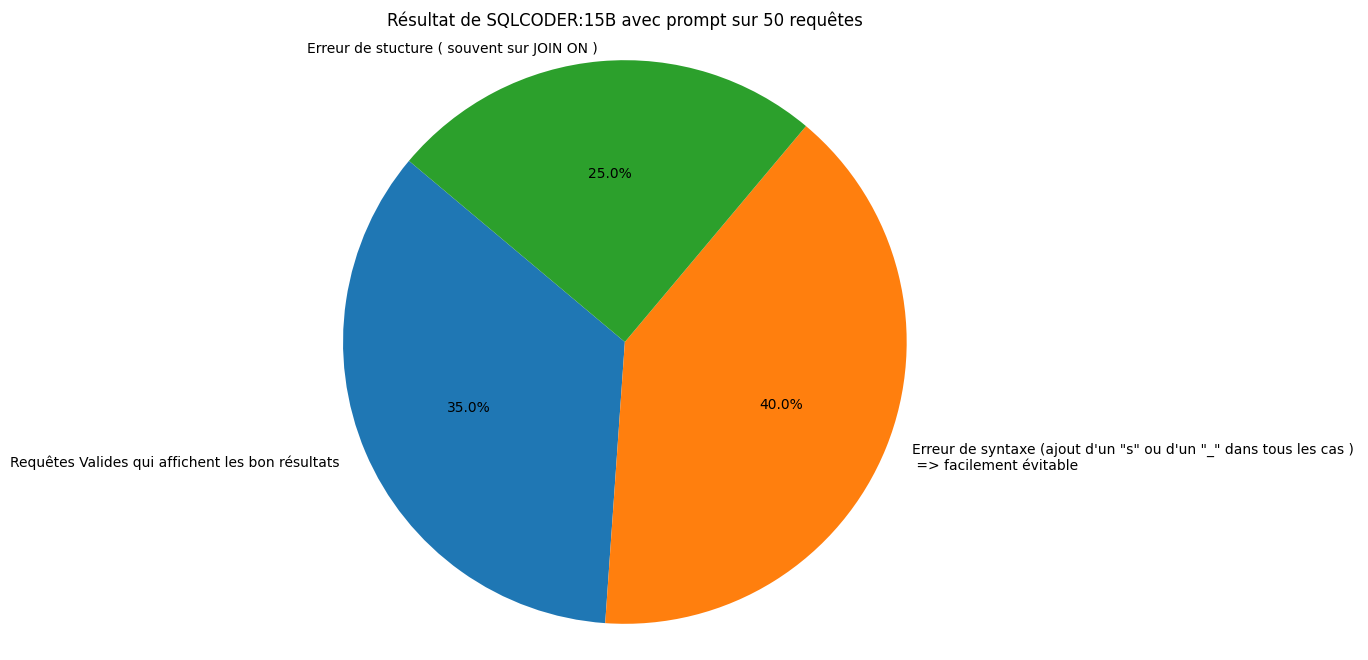

In [178]:
import matplotlib.pyplot as plt 

labels = ['Requêtes Valides qui affichent les bon résultats','Erreur de syntaxe (ajout d\'un "s" ou d\'un "_" dans tous les cas ) \n => facilement évitable','\n \nErreur de stucture ( souvent sur JOIN ON )']
sizes = [7,8,5]

plt.figure(figsize=(8,8))
plt.pie(sizes,labels=labels,autopct='%1.1f%%',startangle=140)
plt.axis('equal')
plt.title('Résultat de SQLCODER:15B avec prompt sur 50 requêtes')
plt.show()

### SQLCODER:34B 

In [5]:
 pip install requests==2.27.1

ERROR: Could not find a version that satisfies the requirement requests==2.27.1 (from versions: none)
ERROR: No matching distribution found for requests==2.27.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
%env http_proxy="http://193.56.47.20:8080"
%env https_proxy="http://193.56.47.20:8080"

env: http_proxy="http://193.56.47.20:8080"
env: https_proxy="http://193.56.47.20:8080"


In [3]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [4]:
# Load model directly

tokenizer = AutoTokenizer.from_pretrained("defog/sqlcoder-34b-alpha")
model = AutoModelForCausalLM.from_pretrained("defog/sqlcoder-34b-alpha")
pipe = pipeline("text-generation",model=model,tokenizer = tokenizer,max_length =3500,do_sample=True,temperature=0.3,top_p=0.95)

template = """
Write a SQL query that retrieves data from the table '{Table}'.
Select the columns {Columns} based on the following question: 
{question}.
Just generate the query without explanation
"""


ProxyError: (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /defog/sqlcoder-34b-alpha/resolve/main/tokenizer_config.json (Caused by ProxyError(\'Unable to connect to proxy\', NameResolutionError(\'<urllib3.connection.HTTPSConnection object at 0x7f1499ccd220>: Failed to resolve \\\'"http\\\' ([Errno -2] Name or service not known)\')))'), '(Request ID: ed8731f2-b511-4bb3-b9be-c0c02b1522da)')

In [18]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("defog/sqlcoder-7b")
model = AutoModelForCausalLM.from_pretrained("defog/sqlcoder-7b")

ProxyError: (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /defog/sqlcoder-7b/resolve/main/tokenizer_config.json (Caused by ProxyError(\'Unable to connect to proxy\', NameResolutionError(\'<urllib3.connection.HTTPSConnection object at 0x7f87e8766130>: Failed to resolve \\\'"http\\\' ([Errno -2] Name or service not known)\')))'), '(Request ID: d1b9e8c1-551e-4854-aad2-87f6a5202f93)')

In [ ]:
prompt = PromptTemplate(template=template, input_variables=["Table","question","Columns"])

local_llm = HuggingFacePipeline(pipeline=pipe)
llm_chain = LLMChain(prompt=prompt,llm=local_llm)

def get_llm_response(tble,question,cols):
    llm_chain = LLMChain(prompt=prompt,llm=llm)
    response= llm_chain.run({"Table" : tble,"question" :question, "Columns" : cols})
    print(response)


In [ ]:
tble = "employee"
cols = ["id","name","date_of_birth","band","manager_id"]
question = "Query the count of employees in band L6"
get_llm_response(tble,question,cols)